Import Package

In [ ]:
import os
import cv2
import csv
import json
import shutil
import kagglehub
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.optimizers import Adam
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

Load Dataset

In [ ]:
path = kagglehub.dataset_download("odins0n/ucf-crime-dataset")
print("Dataset downloaded at:", path)

100%|██████████| 11.0G/11.0G [02:32<00:00, 77.5MB/s]

Extracting files...


Dataset downloaded at: /root/.cache/kagglehub/datasets/odins0n/ucf-crime-dataset/versions/1


Ubah Path Dataset

In [ ]:
!cp -r /root/.cache/kagglehub/datasets/odins0n/ucf-crime-dataset/versions/1 /content/dataset

Ambil 7 Kelas

In [ ]:
source_dir = '/content/dataset/Train'
output_dir = '/content/dataset/Subsets'

os.makedirs(output_dir, exist_ok=True)

chosen_classes = [
    'Abuse', 'Arson', 'NormalVideos', 'Robbery', 'Explosion',
    'Stealing', 'Burglary'
]

subset_dir = os.path.join(output_dir, 'crime_subset')
os.makedirs(subset_dir, exist_ok=True)

for class_name in chosen_classes:
    class_path = os.path.join(source_dir, class_name)
    target_path = os.path.join(subset_dir, class_name)

    if os.path.exists(class_path):

        if os.path.exists(target_path):
            shutil.rmtree(target_path)

        shutil.copytree(class_path, target_path)
        print(f"Kelas '{class_name}' berhasil disalin.")
    else:
        print(f"Kelas '{class_name}' tidak ditemukan di direktori asal.")

print("Subset selesai dibuat.")

Kelas 'Abuse' berhasil disalin.
Kelas 'Arson' berhasil disalin.
Kelas 'NormalVideos' berhasil disalin.
Kelas 'Robbery' berhasil disalin.
Kelas 'Explosion' berhasil disalin.
Kelas 'Stealing' berhasil disalin.
Kelas 'Burglary' berhasil disalin.
Subset selesai dibuat.


Data Augmentasi

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)
train_data = datagen.flow_from_directory(
    subset_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    shuffle=True,
)

val_data = datagen.flow_from_directory(
    subset_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
)

class_labels = train_data.class_indices
print(class_labels)

num_classes = len(train_data.class_indices)

Found 908657 images belonging to 7 classes.
Found 227160 images belonging to 7 classes.
{'Abuse': 0, 'Arson': 1, 'Burglary': 2, 'Explosion': 3, 'NormalVideos': 4, 'Robbery': 5, 'Stealing': 6}


Visualisasi beberapa contoh gambar dari dataset

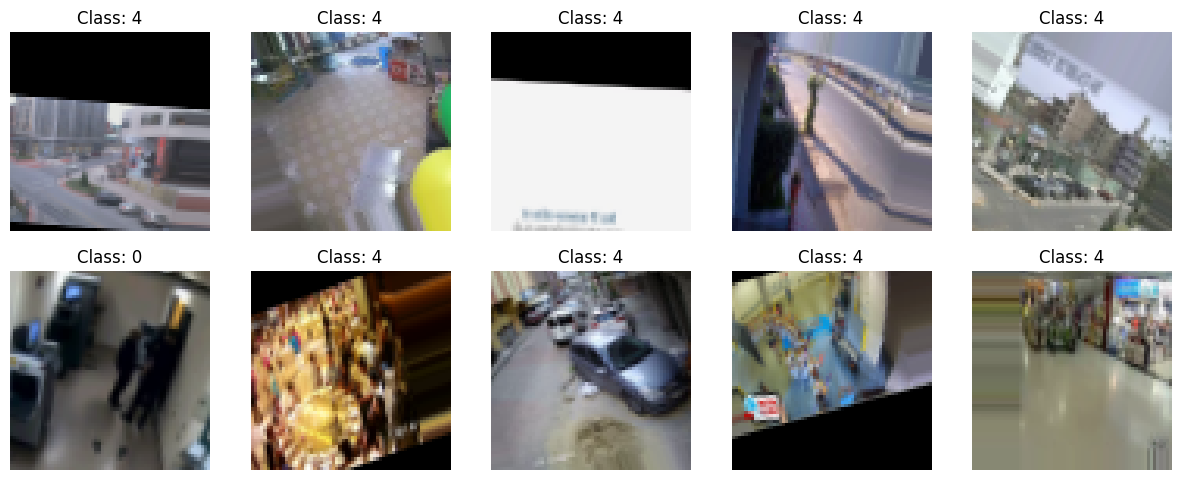

In [ ]:
images, labels = next(train_data)

num_images = 10
plt.figure(figsize=(15, 15))

for i in range(num_images):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[i].argmax()}")
    plt.axis("off")

plt.show()

Image shape

In [ ]:
print("Images Shape:",train_data.image_shape)

Images Shape: (64, 64, 3)


Extract Feature

In [ ]:
base_model = tf.keras.applications.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(64, 64, 3)
)
base_model.trainable = False

Model CNN untuk deteksi anomali multiclass

In [ ]:
model = tf.keras.models.Sequential([
    base_model,
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),

    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')
])


model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 2, 2, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 2, 2, 32)            │         294,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 2, 2, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 2, 2, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 2, 2, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 2, 2, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 2, 2, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │          33,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,434,375 (28.36 MB)

 Trainable params: 396,679 (1.51 MB)

 Non-trainable params: 7,037,696 (26.85 MB)

Training Model

In [ ]:
callbacks = EarlyStopping(
    patience=10,
    monitor='val_accuracy',
    restore_best_weights=True
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

Fine tunning

In [ ]:
history = model.fit(
    train_data,
    epochs=1,
    callbacks=[callbacks, lr_scheduler],
    validation_data=val_data
)

56792/56792 ━━━━━━━━━━━━━━━━━━━━ 16243s 286ms/step - accuracy: 0.9228 - loss: 0.2824 - val_accuracy: 0.7818 - val_loss: 0.8238 - learning_rate: 0.0010


In [ ]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

NameError: name 'base_model' is not defined

In [ ]:
history_fine = model.fit(
    train_data,
    validation_data=val_data,
    epochs=1,
    callbacks=callbacks
)

NameError: name 'model' is not defined

Evaluasi setelah fine tunning

In [ ]:
val_loss, val_acc = model.evaluate(val_data)
print(f"Validation Loss (Fine-Tuning): {val_loss:.4f}")
print(f"Validation Accuracy (Fine-Tuning): {val_acc:.4f}")

14198/14198 ━━━━━━━━━━━━━━━━━━━━ 3215s 226ms/step - accuracy: 0.6717 - loss: 1.5166
Validation Loss (Fine-Tuning): 0.8889
Validation Accuracy (Fine-Tuning): 0.7913


Visualisasi hasil training dan akurasi validasi

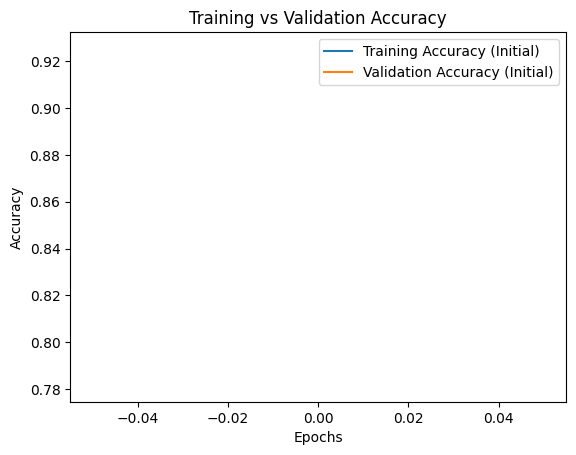

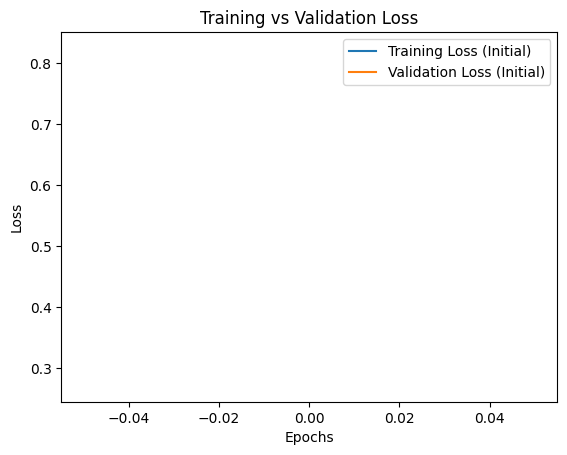

In [ ]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy (Initial)')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (Initial)')
plt.plot(history_fine.history['accuracy'], label='Training Accuracy (Fine-Tune)')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy (Fine-Tune)')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss (Initial)')
plt.plot(history.history['val_loss'], label='Validation Loss (Initial)')
plt.plot(history_fine.history['loss'], label='Training Loss (Fine-Tune)')
plt.plot(history_fine.history['val_loss'], label='Validation Loss (Fine-Tune)')
plt.legend()
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Simpan model ke dalam file .h5

In [ ]:
model_path = "/content/model/anomaly_detection_model.h5"
model.save(model_path)

Visualisasi hasil training

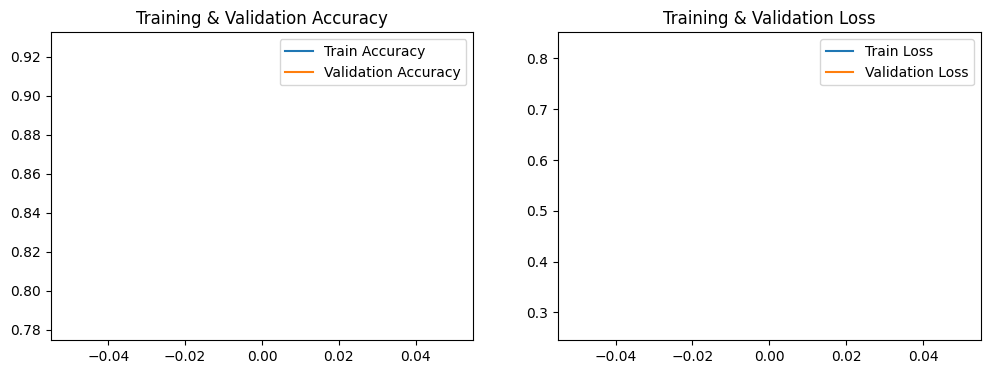

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Training & Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

Uji Model pada Gambar

In [ ]:
uploaded = files.upload()

model = load_model(model_path)

for img_name in uploaded.keys():
    img_path = img_name
    img = image.load_img(img_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model.predict(img_array)

    predicted_class = np.argmax(prediction, axis=1)
    print(f"Predicted class: {predicted_class}")

Saving Fighting003_x264_0.png to Fighting003_x264_0.png


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: [4]
